 Starting Loan Approval Prediction Pipeline

✓ Dataset loaded successfully from C:\Users\MaGheart\Downloads\loan_approval_dataset.csv

 Dataset Shape: (4269, 13)
Columns: ['loan_id', ' no_of_dependents', ' education', ' self_employed', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value', ' loan_status']

 First few rows:
   loan_id   no_of_dependents      education  self_employed   income_annum  \
0        1                  2       Graduate             No        9600000   
1        2                  0   Not Graduate            Yes        4100000   
2        3                  3       Graduate             No        9100000   
3        4                  3       Graduate             No        8200000   
4        5                  5   Not Graduate            Yes        9800000   

    loan_amount   loan_term   cibil_score   residential_assets_value  \
0      29900000         

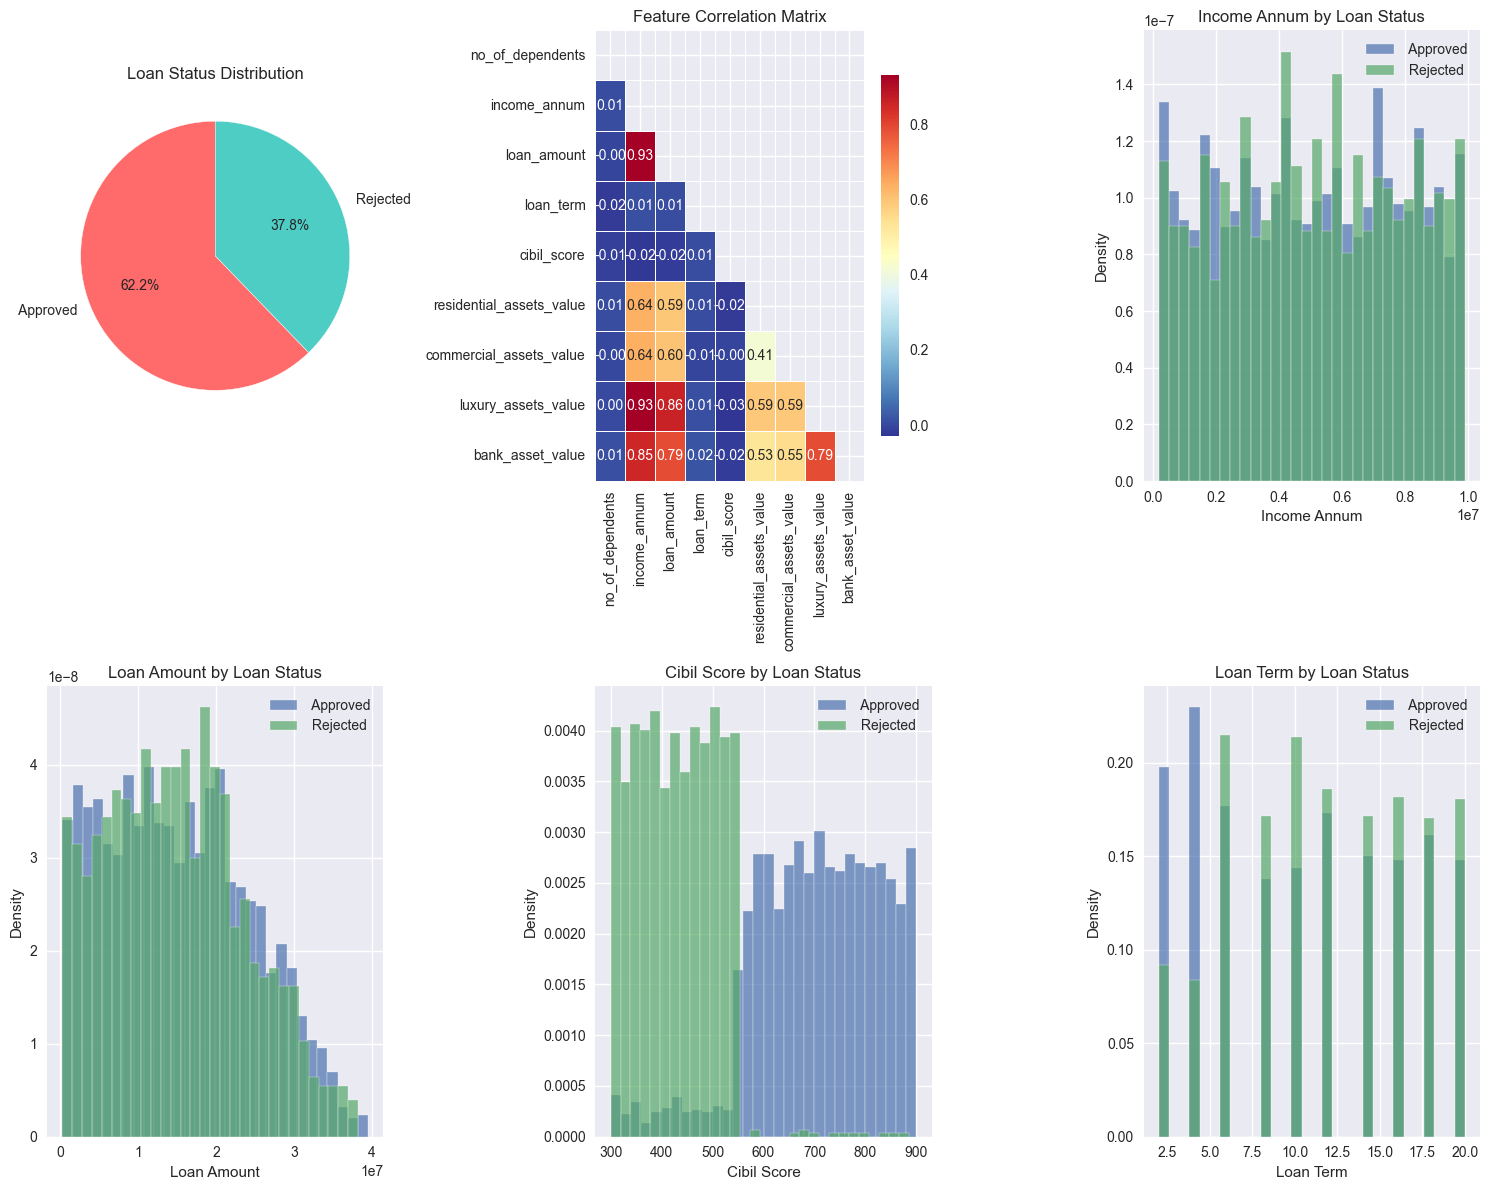

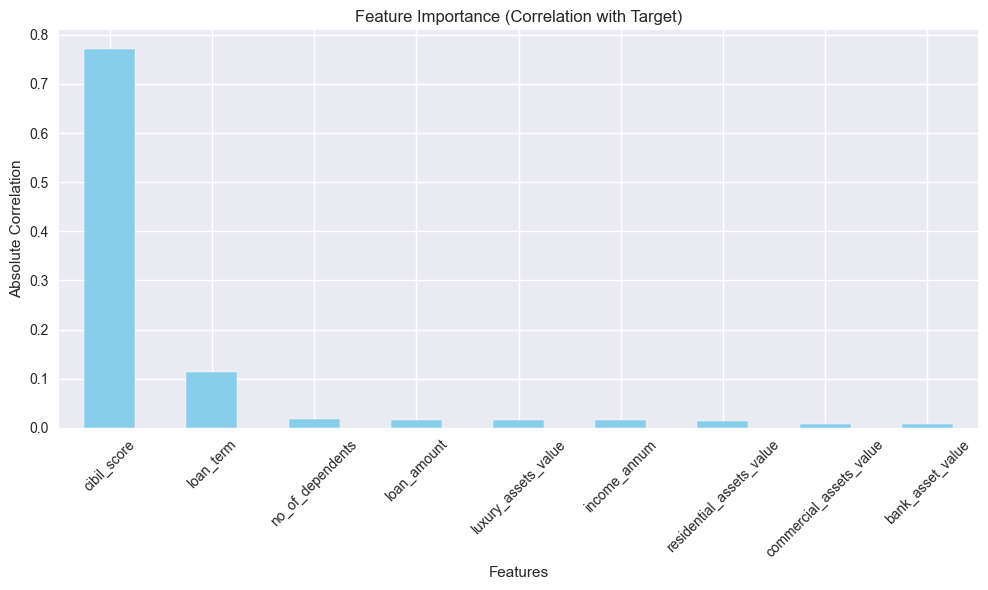

✓ EDA completed
✓ Preprocessing pipeline created

 Training and evaluating models...

 Training RandomForest...
✓ RandomForest - Best CV ROC AUC: 0.9979

 Training LogisticRegression...
✓ LogisticRegression - Best CV ROC AUC: 0.9664

 Training SVM...
✓ SVM - Best CV ROC AUC: 0.9886

 Best model: RandomForest (ROC AUC: 0.9979)
📋 Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}

 Evaluating best model on test set...
 Accuracy: 0.9778
 F1 Score: 0.9705
 ROC AUC: 0.9981


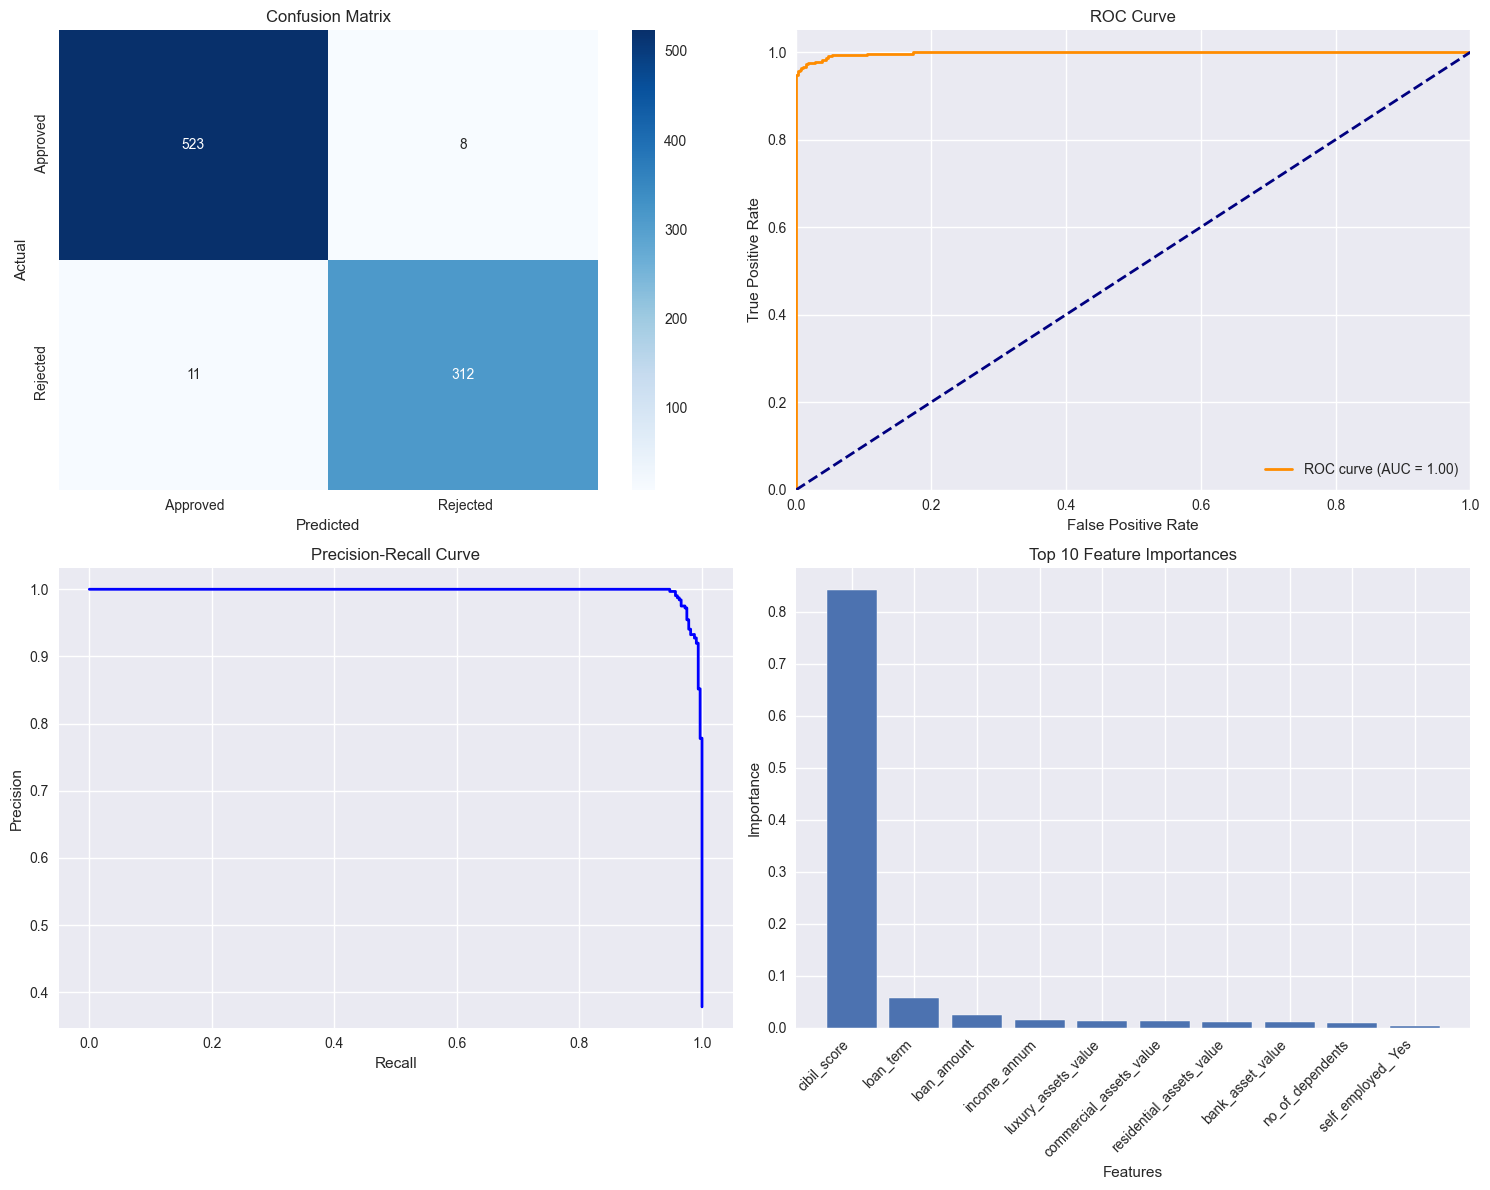


 Detailed Classification Report:
              precision    recall  f1-score   support

    Approved       0.98      0.98      0.98       531
    Rejected       0.97      0.97      0.97       323

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854


 Pipeline completed successfully!

 Sample Prediction:
Application Status:  Approved
Approval Probability: 4.58%
Confidence: 95.42%


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix, 
                           roc_curve, precision_recall_curve, f1_score, accuracy_score)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

class LoanApprovalPredictor:
    """
    A comprehensive loan approval prediction system with automated preprocessing,
    model selection, and evaluation.
    """
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.label_encoder = LabelEncoder()
        self.best_model = None
        self.feature_names = None
        self.preprocessor = None
        
    def load_and_inspect_data(self, file_path=None):
        """Load and perform initial inspection of the dataset."""
        try:
            if file_path:
                self.df = pd.read_csv(file_path)
                print(f"✓ Dataset loaded successfully from {file_path}")
            else:
                # Create dummy data if no file provided
                print("⚠ No file path provided. Creating synthetic dataset for demonstration.")
                self._create_dummy_data()
                
        except FileNotFoundError:
            print(f"File not found: {file_path}")
            print("Creating synthetic dataset for demonstration.")
            self._create_dummy_data()
            
        # Initial data inspection
        print(f"\n Dataset Shape: {self.df.shape}")
        print(f"Columns: {list(self.df.columns)}")
        print("\n First few rows:")
        print(self.df.head())
        
        return self.df
    
    def _create_dummy_data(self, n_samples=1000):
        """Create synthetic loan approval dataset for demonstration."""
        np.random.seed(self.random_state)
        
        data = {
            'loan_id': range(n_samples),
            'no_of_dependents': np.random.randint(0, 6, n_samples),
            'education': np.random.choice(['Graduate', 'Not Graduate'], n_samples, p=[0.7, 0.3]),
            'self_employed': np.random.choice(['Yes', 'No'], n_samples, p=[0.3, 0.7]),
            'income_annum': np.random.lognormal(10.5, 0.8, n_samples).astype(int),
            'loan_amount': np.random.lognormal(11.5, 0.6, n_samples).astype(int),
            'loan_term': np.random.choice([12, 24, 36, 48, 60], n_samples),
            'cibil_score': np.random.normal(650, 100, n_samples).clip(300, 900).astype(int),
            'residential_assets_value': np.random.lognormal(12, 1, n_samples).astype(int),
            'commercial_assets_value': np.random.lognormal(10, 1.5, n_samples).astype(int),
            'luxury_assets_value': np.random.lognormal(9, 1.5, n_samples).astype(int),
            'bank_asset_value': np.random.lognormal(11, 1, n_samples).astype(int)
        }
        
        # Create realistic loan status based on features
        loan_status = []
        for i in range(n_samples):
            # Higher CIBIL score and income increase approval probability
            prob_approved = (data['cibil_score'][i] / 900 * 0.4 + 
                           min(data['income_annum'][i] / 1000000, 1) * 0.3 +
                           (1 if data['education'][i] == 'Graduate' else 0) * 0.2 +
                           np.random.random() * 0.1)
            loan_status.append('Approved' if prob_approved > 0.5 else 'Rejected')
        
        data['loan_status'] = loan_status
        self.df = pd.DataFrame(data)
    
    def preprocess_data(self):
        """Clean and preprocess the dataset."""
        print("\n Starting data preprocessing...")
        
        # Clean column names
        self.df.columns = self.df.columns.str.strip()
        
        # Remove identifier columns
        if 'loan_id' in self.df.columns:
            self.df = self.df.drop('loan_id', axis=1)
        
        # Handle missing values info
        missing_info = self.df.isnull().sum()
        if missing_info.sum() > 0:
            print(f" Found {missing_info.sum()} missing values")
            print(missing_info[missing_info > 0])
        else:
            print("✓ No missing values found")
        
        # Encode target variable
        self.df['loan_status'] = self.label_encoder.fit_transform(self.df['loan_status'])
        print(f"✓ Target variable encoded: {dict(zip(self.label_encoder.classes_, 
                                                     self.label_encoder.transform(self.label_encoder.classes_)))}")
        
        # Separate features and target
        self.X = self.df.drop('loan_status', axis=1)
        self.y = self.df['loan_status']
        
        # Identify feature types
        self.numerical_features = self.X.select_dtypes(include=np.number).columns.tolist()
        self.categorical_features = self.X.select_dtypes(exclude=np.number).columns.tolist()
        
        print(f" Numerical features ({len(self.numerical_features)}): {self.numerical_features}")
        print(f"🏷 Categorical features ({len(self.categorical_features)}): {self.categorical_features}")
        
        return self.X, self.y
    
    def perform_eda(self):
        """Perform comprehensive exploratory data analysis."""
        print("\n Performing Exploratory Data Analysis...")
        
        # Set style
        plt.style.use('seaborn-v0_8')
        
        # 1. Target distribution
        plt.figure(figsize=(15, 12))
        
        plt.subplot(2, 3, 1)
        target_counts = pd.Series(self.y).value_counts()
        colors = ['#FF6B6B', '#4ECDC4']
        plt.pie(target_counts.values, labels=self.label_encoder.classes_, 
                autopct='%1.1f%%', colors=colors, startangle=90)
        plt.title('Loan Status Distribution')
        
        # 2. Correlation heatmap
        plt.subplot(2, 3, 2)
        numeric_df = self.X.select_dtypes(include=np.number)
        correlation_matrix = numeric_df.corr()
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', 
                   fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})
        plt.title('Feature Correlation Matrix')
        
        # 3-6. Key feature distributions
        key_features = ['income_annum', 'loan_amount', 'cibil_score', 'loan_term']
        for i, feature in enumerate(key_features, 3):
            plt.subplot(2, 3, i)
            for status in [0, 1]:
                data = self.X[self.y == status][feature]
                plt.hist(data, alpha=0.7, label=self.label_encoder.classes_[status], 
                        bins=30, density=True)
            plt.xlabel(feature.replace('_', ' ').title())
            plt.ylabel('Density')
            plt.title(f'{feature.replace("_", " ").title()} by Loan Status')
            plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Feature importance analysis using correlation with target
        numeric_corr = numeric_df.corrwith(pd.Series(self.y)).abs().sort_values(ascending=False)
        
        plt.figure(figsize=(10, 6))
        numeric_corr.plot(kind='bar', color='skyblue')
        plt.title('Feature Importance (Correlation with Target)')
        plt.xlabel('Features')
        plt.ylabel('Absolute Correlation')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        print("✓ EDA completed")
    
    def create_preprocessing_pipeline(self):
        """Create preprocessing pipeline for numerical and categorical features."""
        
        # Numerical preprocessing
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        
        # Categorical preprocessing
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
        ])
        
        # Combine preprocessing steps
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, self.numerical_features),
                ('cat', categorical_transformer, self.categorical_features)
            ],
            remainder='passthrough'
        )
        
        print("✓ Preprocessing pipeline created")
        return self.preprocessor
    
    def train_and_evaluate_models(self, test_size=0.2):
        """Train multiple models and select the best one."""
        print("\n Training and evaluating models...")
        
        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=self.random_state, stratify=self.y
        )
        
        # Define models and their parameter grids
        models = {
            'RandomForest': {
                'model': RandomForestClassifier(random_state=self.random_state),
                'params': {
                    'classifier__n_estimators': [100, 200],
                    'classifier__max_depth': [10, 20, None],
                    'classifier__min_samples_split': [2, 5],
                    'classifier__min_samples_leaf': [1, 2]
                }
            },
            'LogisticRegression': {
                'model': LogisticRegression(random_state=self.random_state, max_iter=1000),
                'params': {
                    'classifier__C': [0.1, 1, 10],
                    'classifier__penalty': ['l1', 'l2'],
                    'classifier__solver': ['liblinear']
                }
            },
            'SVM': {
                'model': SVC(random_state=self.random_state, probability=True),
                'params': {
                    'classifier__C': [0.1, 1, 10],
                    'classifier__kernel': ['rbf', 'linear'],
                    'classifier__gamma': ['scale', 'auto']
                }
            }
        }
        
        best_score = 0
        best_model_name = None
        results = {}
        
        # Cross-validation strategy
        cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)
        
        for name, model_config in models.items():
            print(f"\n Training {name}...")
            
            # Create pipeline
            pipeline = Pipeline(steps=[
                ('preprocessor', self.preprocessor),
                ('sampler', SMOTE(random_state=self.random_state)),
                ('classifier', model_config['model'])
            ])
            
            # Grid search
            grid_search = GridSearchCV(
                pipeline, 
                model_config['params'], 
                cv=cv_strategy,
                scoring='roc_auc', 
                n_jobs=-1, 
                verbose=0
            )
            
            grid_search.fit(self.X_train, self.y_train)
            
            # Store results
            results[name] = {
                'best_model': grid_search.best_estimator_,
                'best_params': grid_search.best_params_,
                'best_score': grid_search.best_score_
            }
            
            print(f"✓ {name} - Best CV ROC AUC: {grid_search.best_score_:.4f}")
            
            # Update best model
            if grid_search.best_score_ > best_score:
                best_score = grid_search.best_score_
                best_model_name = name
                self.best_model = grid_search.best_estimator_
        
        print(f"\n Best model: {best_model_name} (ROC AUC: {best_score:.4f})")
        print(f"📋 Best parameters: {results[best_model_name]['best_params']}")
        
        return results
    
    def evaluate_model(self):
        """Comprehensive model evaluation on test set."""
        print("\n Evaluating best model on test set...")
        
        # Predictions
        y_pred = self.best_model.predict(self.X_test)
        y_pred_proba = self.best_model.predict_proba(self.X_test)[:, 1]
        
        # Metrics
        accuracy = accuracy_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred)
        roc_auc = roc_auc_score(self.y_test, y_pred_proba)
        
        print(f" Accuracy: {accuracy:.4f}")
        print(f" F1 Score: {f1:.4f}")
        print(f" ROC AUC: {roc_auc:.4f}")
        
        # Visualizations
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Confusion Matrix
        cm = confusion_matrix(self.y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=self.label_encoder.classes_, 
                   yticklabels=self.label_encoder.classes_, ax=axes[0, 0])
        axes[0, 0].set_title('Confusion Matrix')
        axes[0, 0].set_ylabel('Actual')
        axes[0, 0].set_xlabel('Predicted')
        
        # 2. ROC Curve
        fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
        axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, 1].set_xlim([0.0, 1.0])
        axes[0, 1].set_ylim([0.0, 1.05])
        axes[0, 1].set_xlabel('False Positive Rate')
        axes[0, 1].set_ylabel('True Positive Rate')
        axes[0, 1].set_title('ROC Curve')
        axes[0, 1].legend(loc="lower right")
        
        # 3. Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(self.y_test, y_pred_proba)
        axes[1, 0].plot(recall, precision, color='blue', lw=2)
        axes[1, 0].set_xlabel('Recall')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].set_title('Precision-Recall Curve')
        axes[1, 0].grid(True)
        
        # 4. Feature Importance (if available)
        if hasattr(self.best_model.named_steps['classifier'], 'feature_importances_'):
            # Get feature names after preprocessing
            feature_names = (self.numerical_features + 
                           list(self.best_model.named_steps['preprocessor']
                               .named_transformers_['cat']
                               .named_steps['onehot']
                               .get_feature_names_out(self.categorical_features)))
            
            importances = self.best_model.named_steps['classifier'].feature_importances_
            indices = np.argsort(importances)[::-1][:10]  # Top 10 features
            
            axes[1, 1].bar(range(len(indices)), importances[indices])
            axes[1, 1].set_title('Top 10 Feature Importances')
            axes[1, 1].set_xlabel('Features')
            axes[1, 1].set_ylabel('Importance')
            axes[1, 1].set_xticks(range(len(indices)))
            axes[1, 1].set_xticklabels([feature_names[i] for i in indices], rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
        
        # Classification report
        print("\n Detailed Classification Report:")
        print(classification_report(self.y_test, y_pred, target_names=self.label_encoder.classes_))
        
        return {
            'accuracy': accuracy,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
    
    def predict_single_application(self, application_data):
        """Predict loan approval for a single application."""
        if self.best_model is None:
            raise ValueError("Model not trained yet. Please run the full pipeline first.")
        
        # Convert to DataFrame if necessary
        if isinstance(application_data, dict):
            application_data = pd.DataFrame([application_data])
        
        # Make prediction
        prediction = self.best_model.predict(application_data)[0]
        probability = self.best_model.predict_proba(application_data)[0]
        
        result = {
            'prediction': self.label_encoder.classes_[prediction],
            'probability_rejected': probability[0],
            'probability_approved': probability[1],
            'confidence': max(probability)
        }
        
        return result
    
    def run_full_pipeline(self, file_path=None):
        """Run the complete loan approval prediction pipeline."""
        print(" Starting Loan Approval Prediction Pipeline\n")
        print("=" * 60)
        
        # Step 1: Load data
        self.load_and_inspect_data(file_path)
        
        # Step 2: Preprocess data
        self.preprocess_data()
        
        # Step 3: EDA
        self.perform_eda()
        
        # Step 4: Create preprocessing pipeline
        self.create_preprocessing_pipeline()
        
        # Step 5: Train and evaluate models
        results = self.train_and_evaluate_models()
        
        # Step 6: Final evaluation
        evaluation_results = self.evaluate_model()
        
        print("\n" + "=" * 60)
        print(" Pipeline completed successfully!")
        print("=" * 60)
        
        return {
            'model_results': results,
            'evaluation': evaluation_results,
            'best_model': self.best_model
        }

# Example usage
if __name__ == "__main__":
    # Initialize predictor
    predictor = LoanApprovalPredictor()
    
    # Run full pipeline
    # Replace with your actual file path
    file_path = r"C:\Users\MaGheart\Downloads\loan_approval_dataset.csv"
    results = predictor.run_full_pipeline(file_path)
    
    # Example single prediction
    sample_application = {
        'no_of_dependents': 2,
        'education': 'Graduate',
        'self_employed': 'No',
        'income_annum': 500000,
        'loan_amount': 200000,
        'loan_term': 36,
        'cibil_score': 750,
        'residential_assets_value': 800000,
        'commercial_assets_value': 100000,
        'luxury_assets_value': 50000,
        'bank_asset_value': 200000
    }
    
    try:
        prediction_result = predictor.predict_single_application(sample_application)
        print(f"\n Sample Prediction:")
        print(f"Application Status: {prediction_result['prediction']}")
        print(f"Approval Probability: {prediction_result['probability_approved']:.2%}")
        print(f"Confidence: {prediction_result['confidence']:.2%}")
    except ValueError as e:
        print(f"Prediction error: {e}")